# Сегментация изображений

---


1.Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).


2. Разархивируем .rar файл.
3. Папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании нужно сегментировать их.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

--2021-01-18 10:09:18--  https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.7.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.7.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/k88qukc20ljnbuo/PH2Dataset.rar [following]
--2021-01-18 10:09:19--  https://www.dropbox.com/s/raw/k88qukc20ljnbuo/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc42ce06839cd3020f92b8313691.dl.dropboxusercontent.com/cd/0/inline/BHMGCe1L-ybiuy7irfk3POCLeLGiMTx5W6l4PfTuT-seCYEkyoB8nLVh3Nnb3NPHPWbpIOtz-NGCnAPGzhFzm035Jd9SR4m4VBiajQqw_1VTZw/file# [following]
--2021-01-18 10:09:19--  https://uc42ce06839cd3020f92b8313691.dl.dropboxusercontent.com/cd/0/inline/BHMGCe1L-ybiuy7irfk3POCLeLGiMTx5W6l4PfTuT-seCYEkyoB8nLVh3Nnb3NPHPWbpIOtz-NGCnAPGzhFzm035Jd9SR4m4VBiajQqw_1VTZw/file
Resolving 

In [3]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Для загрузки датасета используем skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [4]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) можно использовать для изменения размера изображений. 
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [5]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [6]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [7]:
len(lesions)

200

Нарисуем несколько изображений

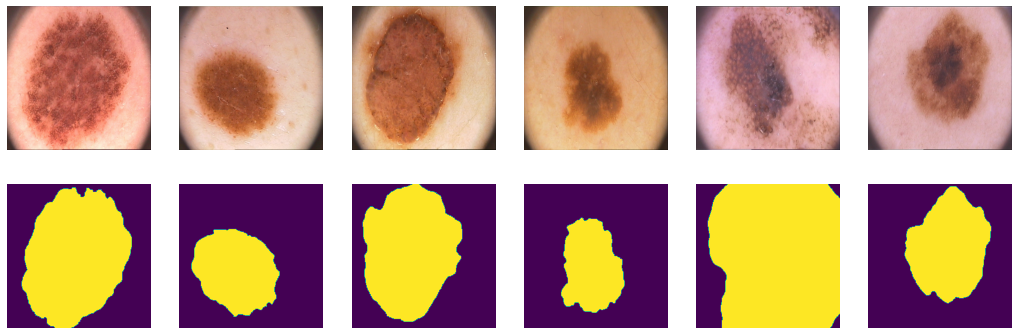

In [8]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [9]:
#np.random.seed(42)
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [10]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [11]:
from torch.utils.data import DataLoader

batch_size = 6
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [12]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Задание состоит в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet 

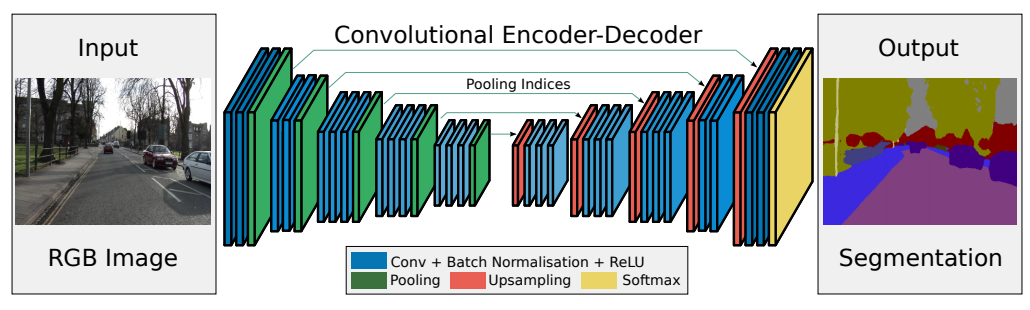

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
import pandas as pd

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,6)
import seaborn as sns
sns.set()

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Encoder Stage - 1
        self.enc_conv0 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64,  64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 256 -> 128

        # Encoder Stage - 2
        self.enc_conv1 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128,  128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 128 -> 64

        # Encoder Stage - 3
        self.enc_conv2 = nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32

        # Encoder Stage - 4
        self.enc_conv3 = nn.Sequential(
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16

        # bottleneck
        # Encoder Stage - 5
        self.enc_conv4 = nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU()
        )
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        # decoder (upsampling)
        # Decoder Stage - 5
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(                                       
        nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU()
        )

        # Decoder Stage - 4
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(                                       
        nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU()
        )

        # Decoder Stage - 3
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(                                       
        nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU()
        )

        # Decoder Stage - 2
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(                                       
        nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64)
        )

        # Decoder Stage - 1
        self.upsample4 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 256 -> 256
        self.dec_conv4 = nn.Sequential(                                       
        nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
        )

    def forward(self, x):
        # encoder
        e0, pool0_idx = self.pool0(self.enc_conv0(x))
        #print('1', e0.shape, pool0_idx.shape)
        e1, pool1_idx = self.pool1(self.enc_conv1(e0))
        #print('2', e1.shape, pool1_idx.shape)
        e2, pool2_idx = self.pool2(self.enc_conv2(e1))
        #print('3', e2.shape, pool2_idx.shape)
        e3, pool3_idx = self.pool3(self.enc_conv3(e2))
        #print('4', e3.shape, pool3_idx.shape)

        # bottleneck
        b, pool4_idx = self.pool4(self.enc_conv4(e3))
        b = self.dec_conv0(self.upsample0(b, pool4_idx))

        # decoder
        d0 = self.dec_conv1(self.upsample1(b, pool3_idx))
        d1 = self.dec_conv2(self.upsample2(d0, pool2_idx))
        d2 = self.dec_conv3(self.upsample3(d1, pool1_idx))
        d3 = self.dec_conv4(self.upsample4(d2, pool0_idx))  # no activation
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


To clarify this we can see on the segmentation:
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


And the intersection will be the following:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Функция потерь

Теперь не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) в Тарая функция эквивалентна и не так подвержена численной неустойчивости.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_pred, y_real):
    loss = torch.mean(y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred)))
    return loss

Проверим корректность написания формулы:

In [ ]:
s1 = torch.randn(1, 256, 256)
s2 = torch.randn(1, 256, 256)
print(nn.BCEWithLogitsLoss()(s1, s2), bce_loss(s1, s2))

tensor(0.8061) tensor(0.8061)


## Тренировка

Определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def train(model, optim, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    history = []
    best_model_wts = model.state_dict()
    best_loss = 1e4

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_tr_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            optim.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch) # forward-pass
            loss.backward()  # backward-pass
            optim.step()  # update weights

            # calculate loss to show the user
            avg_tr_loss += loss / len(data_tr)


        toc = time()
        print('train loss: %f' % avg_tr_loss)

        avg_val_loss = 0
        # show intermediate results
        model.eval()  # testing mode
        for X_batch, Y_batch in data_val:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            with torch.set_grad_enabled(False):
                Y_pred = model(X_batch)
                loss = loss_fn(Y_pred, Y_batch)
                avg_val_loss += loss / len(data_val)
                #preds = torch.argmax(outputs, 1)

                if avg_val_loss < best_loss:
                    best_loss = avg_val_loss
                    best_model_wts = model.state_dict()
        
        history.append((avg_tr_loss, avg_val_loss))
        toc = time()
        print('val loss: %f' % avg_val_loss)
        
        Y_hat = model(X_val.to(device)).detach().cpu() # detach and put into cpu
        
        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            plt.imshow(Y_hat[k, 0] > 0.5, cmap='gray')
            plt.title('Mask')
            plt.axis('off')
        plt.suptitle('%d / %d - train loss: %f, val loss: %f' % (epoch+1, epochs, avg_tr_loss, avg_val_loss))
        plt.show()

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return history

## Инференс

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    scores_history = []
    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        Y_pred = model(X_batch)
        score = metric(torch.sigmoid(Y_pred) > 0.5, Y_label.to(device)).mean().item()
        scores += score
        scores_history.append(score)
    print('Average IoU metric score: {:.4f}'.format(scores/len(data)))
    return scores_history

## Обучение



In [ ]:
model_segnet_bce = SegNet().to(device)

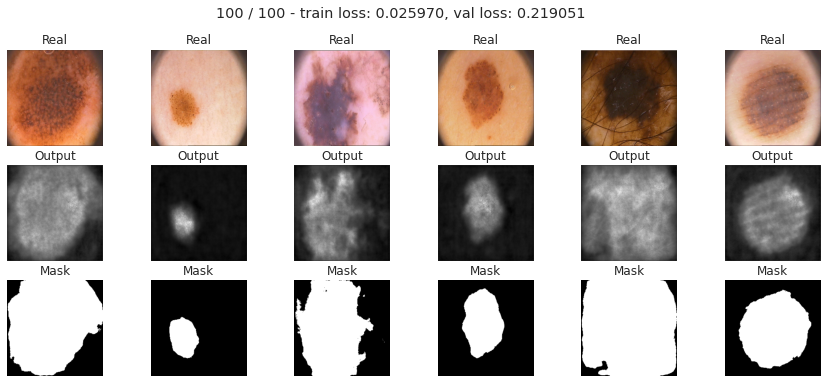

CPU times: user 8min 58s, sys: 4min 5s, total: 13min 4s
Wall time: 13min 5s


In [ ]:
%%time
max_epochs = 100
optim = torch.optim.Adam(model_segnet_bce.parameters(), lr=1e-4)
segnet_bce_history = train(model_segnet_bce, optim, bce_loss, max_epochs, data_tr, data_val)

Сохраним веса

In [ ]:
torch.save(model_segnet_bce.state_dict(), '/content/gdrive/MyDrive/Colab Notebooks/Model weights/model_segnet_bce.pth')

In [ ]:
model_segnet_bce.load_state_dict(torch.load('/content/gdrive/MyDrive/Colab Notebooks/Model weights/model_segnet_bce.pth'))

<All keys matched successfully>

Сохраним лоссы

In [ ]:
def tr_val_loss(history):
    tr_loss, val_loss = zip(*history)
    tr_loss = [round(tr_loss[i].item(), 4) for i in range(len(tr_loss))]
    val_loss = [round(val_loss[i].item(), 4) for i in range(len(val_loss))]
    return tr_loss, val_loss

In [ ]:
segnet_bce_tr_loss, segnet_bce_val_loss = tr_val_loss(segnet_bce_history)

In [ ]:
df_segnet_bce = pd.DataFrame(segnet_bce_val_loss, columns=['segnet_bce_val_loss'])

In [ ]:
df_segnet_bce.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Model weights/df_segnet_bce.csv', index=False)

In [ ]:
df_segnet_bce = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Model weights/df_segnet_bce.csv')

Измерим метрики:

In [ ]:
segnet_bce_tr_metric =  score_model(model_segnet_bce, iou_pytorch, data_tr)

Average IoU metric score: 0.9721


In [ ]:
segnet_bce_val_metric =  score_model(model_segnet_bce, iou_pytorch, data_val)

Average IoU metric score: 0.7963


In [ ]:
segnet_bce_ts_metric = score_model(model_segnet_bce, iou_pytorch, data_ts)

Average IoU metric score: 0.7796


In [ ]:
def train_curves_and_metrics(train_history, val_metric, ts_metric, title_1, title_2):
    tr_loss, val_loss = zip(*train_history)

    plt.figure(figsize=(15, 10))
    plt.subplot(2, 1, 1)
    plt.plot(tr_loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title(title_1)
    plt.show()

    plt.subplot(2, 1, 2)
    plt.plot(val_metric, label="val_metric")
    plt.plot(ts_metric, label="test_metric")
    plt.legend(loc='best')
    plt.xlabel("batch")
    plt.ylabel("IoU")
    plt.title(title_2)
    plt.show()

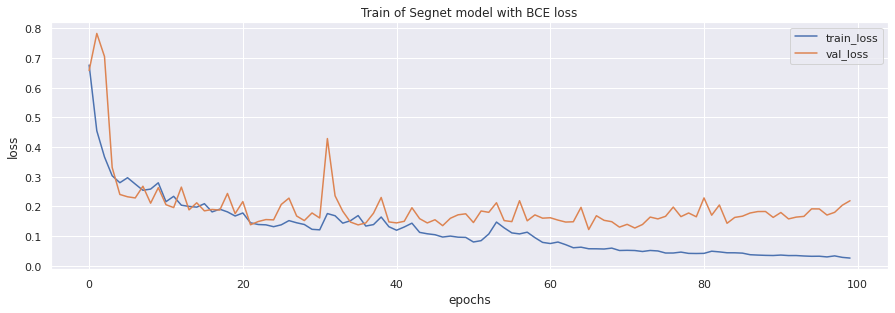

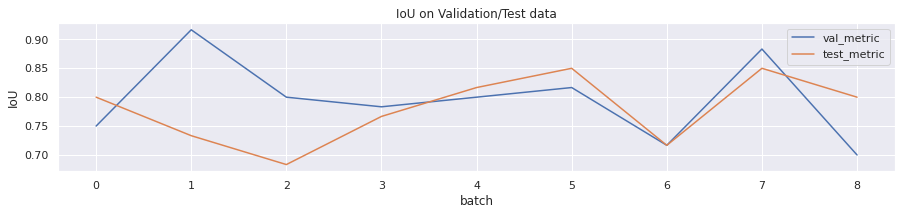

In [ ]:
train_curves_and_metrics(segnet_bce_history, segnet_bce_val_metric, segnet_bce_ts_metric, 
                         'Train of Segnet model with BCE loss',
                         'IoU on Validation/Test data')

Модель SegNet с BCE начинает переобучается после 60 эпохи,но показывает неплохое качаство на тесте.

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь

 В данном разделе необходимо имплементировать две функции потерь:
 DICE и Focal loss. 


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$



In [ ]:
def dice_loss(y_pred, y_real):
    smooth = 1e-6
    real = y_real.view(-1)
    y_pred = torch.sigmoid(y_pred)
    pred = y_pred.view(-1)

    num = torch.sum(real * pred)
    den = torch.sum(real + pred)
    res = 1 - torch.mean(2 * num/ (den + smooth))
    return res

Обучение

In [ ]:
model_segnet_dice = SegNet().to(device)

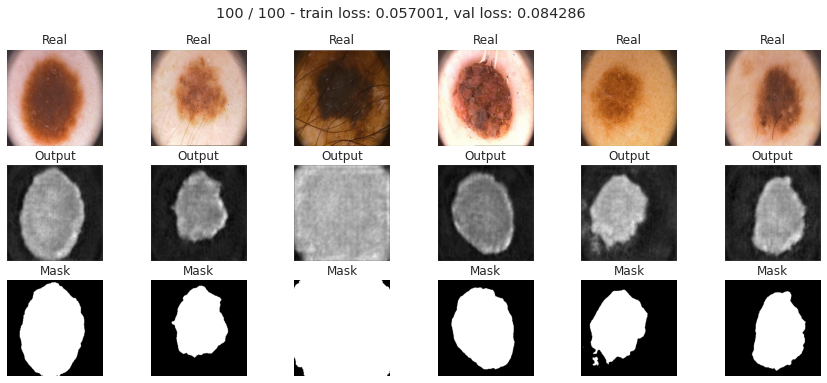

CPU times: user 8min 39s, sys: 4min 2s, total: 12min 41s
Wall time: 12min 42s


In [ ]:
%%time
max_epochs = 100
optimaizer = torch.optim.Adam(model_segnet_dice.parameters(), lr=1e-4)
dice_segnet_history = train(model_segnet_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

Сохраним веса

In [ ]:
torch.save(model_segnet_dice.state_dict(), '/content/gdrive/MyDrive/Colab Notebooks/Model weights/model_segnet_dice.pth')

In [ ]:
model_segnet_dice.load_state_dict(torch.load('/content/gdrive/MyDrive/Colab Notebooks/Model weights/model_segnet_dice.pth'))

<All keys matched successfully>

Сохраним лоссы

In [ ]:
segnet_dice_tr_loss, segnet_dice_val_loss = tr_val_loss(dice_segnet_history)

In [ ]:
df_segnet_dice = pd.DataFrame(segnet_dice_val_loss, columns=['segnet_dice_val_loss'])

In [ ]:
df_segnet_dice.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Model weights/df_segnet_dice.csv', index=False)

In [ ]:
df_segnet_dice = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Model weights/df_segnet_dice.csv')

Измерим метрики:

In [ ]:
segnet_dice_tr_metric = score_model(model_segnet_dice, iou_pytorch, data_tr)

Average IoU metric score: 0.7130


In [ ]:
segnet_dice_val_metric = score_model(model_segnet_dice, iou_pytorch, data_val)

Average IoU metric score: 0.7315


In [ ]:
segnet_dice_ts_metric = score_model(model_segnet_dice, iou_pytorch, data_ts)

Average IoU metric score: 0.8056


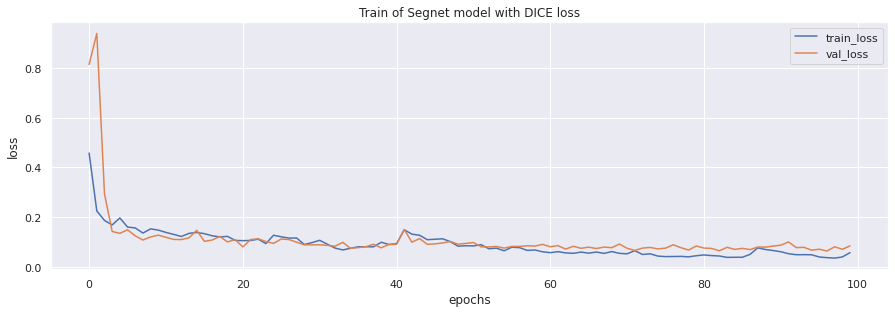

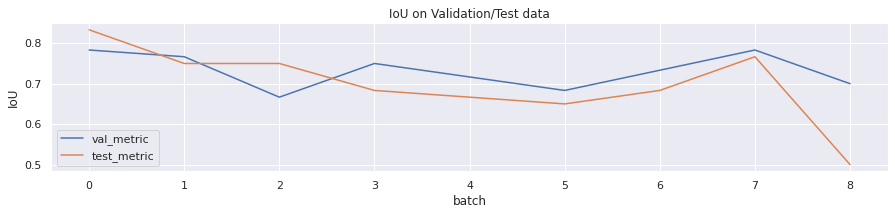

In [ ]:
train_curves_and_metrics(dice_segnet_history, segnet_dice_val_metric, segnet_dice_ts_metric, 
                         'Train of Segnet model with DICE loss',
                         'IoU on Validation/Test data')

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_pred, y_real, eps = 1e-8, gamma = 2):
    y_pred = torch.clamp(y_pred, eps, 1) # hint: torch.clamp
    your_loss = 1 * (1 - torch.exp(-bce_loss(y_pred, y_real)))**gamma * bce_loss(y_pred, y_real)
    return your_loss

In [ ]:
model_segnet_focal = SegNet().to(device)

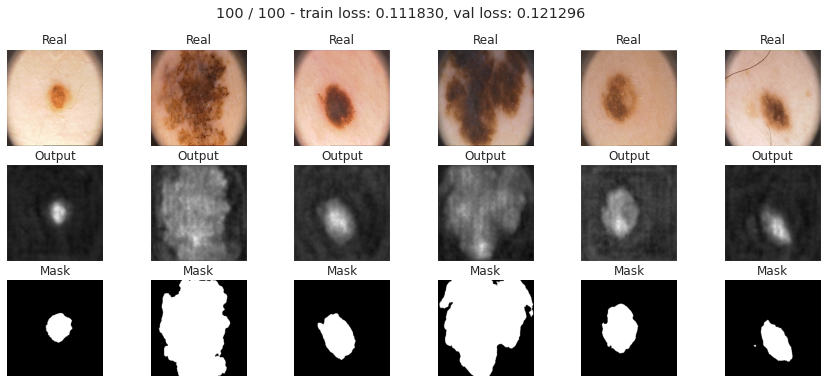

CPU times: user 8min 42s, sys: 4min 5s, total: 12min 47s
Wall time: 12min 48s


In [ ]:
%%time
max_epochs = 100
optimaizer = torch.optim.Adam(model_segnet_focal.parameters(), lr=1e-4)
segnet_focal_history = train(model_segnet_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

Сохраним веса

In [ ]:
torch.save(model_segnet_focal.state_dict(), '/content/gdrive/MyDrive/Colab Notebooks/Model weights/model_segnet_focal.pth')

In [ ]:
model_segnet_focal.load_state_dict(torch.load('/content/gdrive/MyDrive/Colab Notebooks/Model weights/model_segnet_focal.pth'))

<All keys matched successfully>

Сохраним лоссы

In [ ]:
segnet_focal_tr_loss, segnet_focal_val_loss = tr_val_loss(segnet_focal_history)

In [ ]:
df_segnet_focal = pd.DataFrame(segnet_focal_val_loss, columns=['segnet_focal_val_loss'])

In [ ]:
df_segnet_focal.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Model weights/df_segnet_focal.csv', index=False)

In [ ]:
df_segnet_focal = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Model weights/df_segnet_focal.csv')

Измерим метрики:

In [ ]:
segnet_focal_tr_metric = score_model(model_segnet_focal, iou_pytorch, data_tr)

Average IoU metric score: 0.9672


In [ ]:
segnet_focal_val_metric = score_model(model_segnet_focal, iou_pytorch, data_val)

Average IoU metric score: 0.7667


In [ ]:
segnet_focal_ts_metric = score_model(model_segnet_focal, iou_pytorch, data_ts)

Average IoU metric score: 0.8278


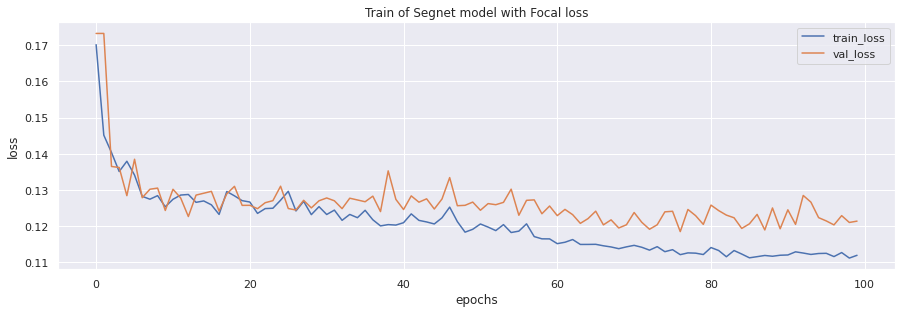

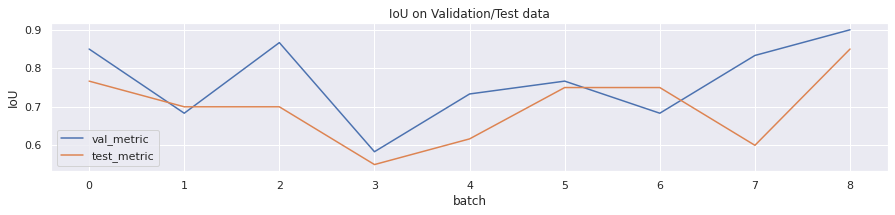

In [ ]:
train_curves_and_metrics(segnet_focal_history, segnet_focal_val_metric, segnet_focal_ts_metric, 
                         'Train of Segnet model with Focal loss',
                         'IoU on Validation/Test data')

Модель SegNet с Focal loss не показывает признаков переобучения до 80 эпохи, также показывает неплохое качаство на тесте.

## Реализуем функцию потерь Тверский лосс 

In [ ]:
def tversky_loss(y_pred, y_real, beta=0.7):
    smooth = 1e-6
    real = y_real.view(-1)
    y_pred = torch.sigmoid(y_pred)
    pred = y_pred.view(-1)

    TP = torch.sum(real * pred) # TP
    FP = torch.sum(pred * (1 - real)) # FP
    FN = torch.sum((1 - pred) * real) # FN
    tversky_loss = 1 - TP / (TP + beta * FP + (1 - beta) * FN + smooth)
    return torch.mean(tversky_loss)

In [ ]:
model_segnet_tversky = SegNet().to(device)

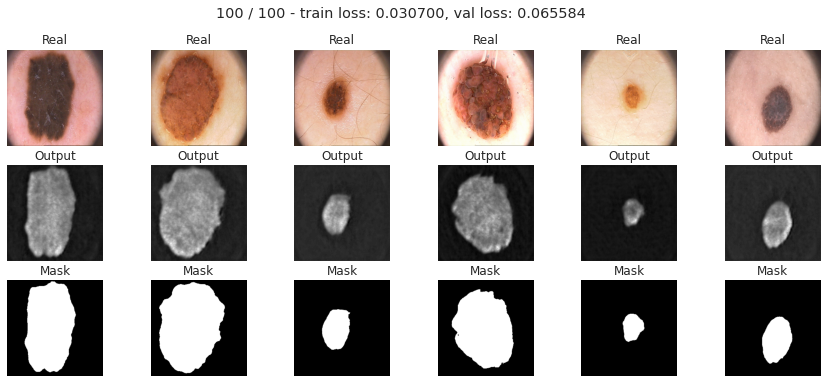

CPU times: user 8min 45s, sys: 4min 7s, total: 12min 52s
Wall time: 12min 53s


In [ ]:
%%time
max_epochs = 100
optim = torch.optim.Adam(model_segnet_tversky.parameters(), lr=1e-4)
segnet_tversky_history = train(model_segnet_tversky, optim, tversky_loss, max_epochs, data_tr, data_val)

Сохраним веса

In [ ]:
torch.save(model_segnet_tversky.state_dict(), '/content/gdrive/MyDrive/Colab Notebooks/Model weights/model_segnet_tversky.pth')

In [ ]:
model_segnet_tversky.load_state_dict(torch.load('/content/gdrive/MyDrive/Colab Notebooks/Model weights/model_segnet_tversky.pth'))

<All keys matched successfully>

Сохраним лоссы

In [ ]:
segnet_tversky_tr_loss, segnet_tversky_val_loss = tr_val_loss(segnet_tversky_history)

In [ ]:
df_segnet_tversky = pd.DataFrame(segnet_tversky_val_loss, columns=['segnet_tversky_val_loss'])

In [ ]:
df_segnet_tversky.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Model weights/df_segnet_tversky.csv', index=False)

In [ ]:
df_segnet_tversky = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Model weights/df_segnet_tversky.csv')

Измерим метрики:

In [ ]:
segnet_tversky_tr_metric = score_model(model_segnet_tversky, iou_pytorch, data_tr)

Average IoU metric score: 0.8554


In [ ]:
segnet_tversky_val_metric = score_model(model_segnet_tversky, iou_pytorch, data_val)

Average IoU metric score: 0.7259


In [ ]:
segnet_tversky_ts_metric = score_model(model_segnet_tversky, iou_pytorch, data_ts)

Average IoU metric score: 0.7852


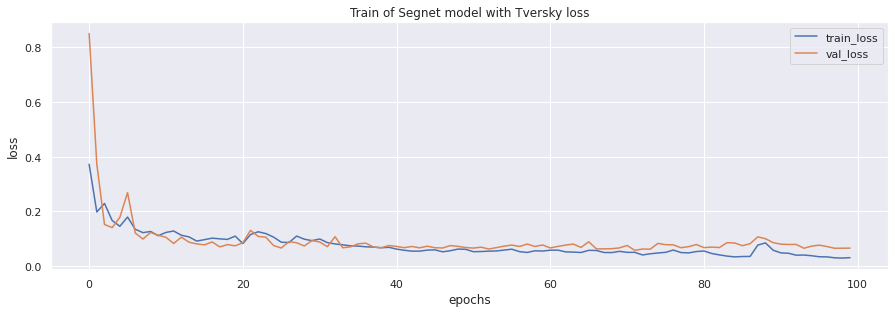

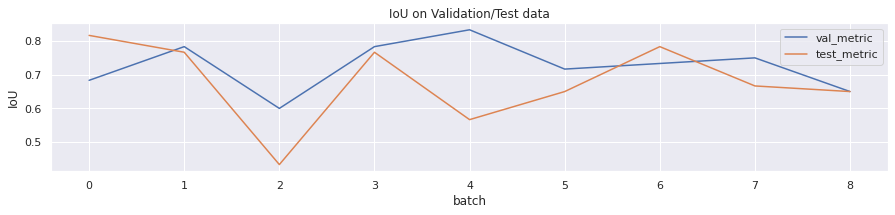

In [ ]:
train_curves_and_metrics(segnet_tversky_history, segnet_tversky_val_metric, segnet_tversky_ts_metric, 
                         'Train of Segnet model with Tversky loss',
                         'IoU on Validation/Test data')

Модель с Tversky loss не склонна к сильному переобучению. Модель показывает хорошие графики на обучении и валидации, но качество на тесте ниже других

Сравним все лоссы для модели SegNet на валидации во время обучения:

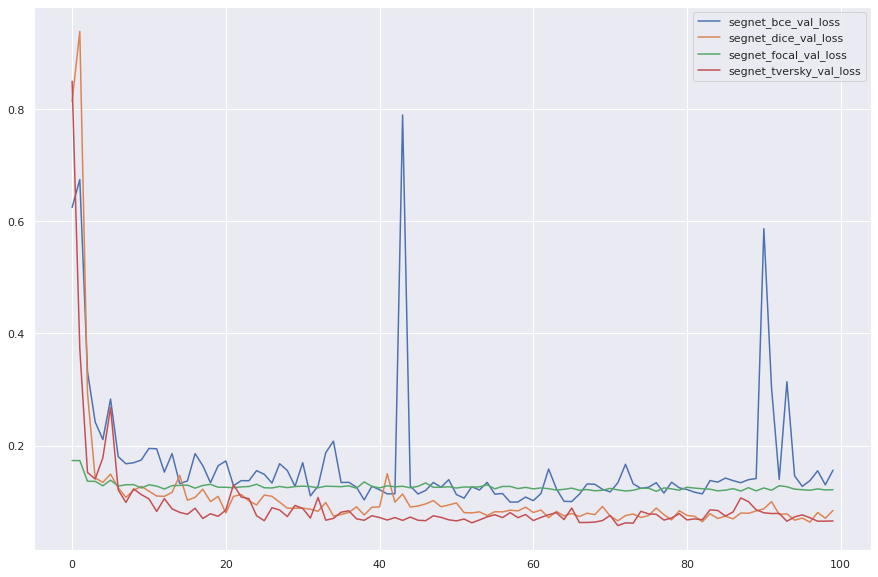

In [ ]:
frames_losses = [df_segnet_bce, df_segnet_dice, df_segnet_focal, df_segnet_tversky]
df_segnet_losses = pd.concat(frames_losses, axis=1)

plt.figure(figsize=(15,10))
plt.plot(df_segnet_losses)
plt.legend(df_segnet_losses.columns);

По значению лосса лучше выгляит segnet c tversky loss, однако focal более стабилен, по сравнению с другими. 

Построим графики метрики на тестовой выборке для модели с каждым из 4 лоссов:

Среднее значение метрики на тестовой выборке:


segnet_bce_ts_metric        0.803704
segnet_dice_ts_metric       0.805556
segnet_focal_ts_metric      0.827778
segnet_tversky_ts_metric    0.785185
dtype: float64

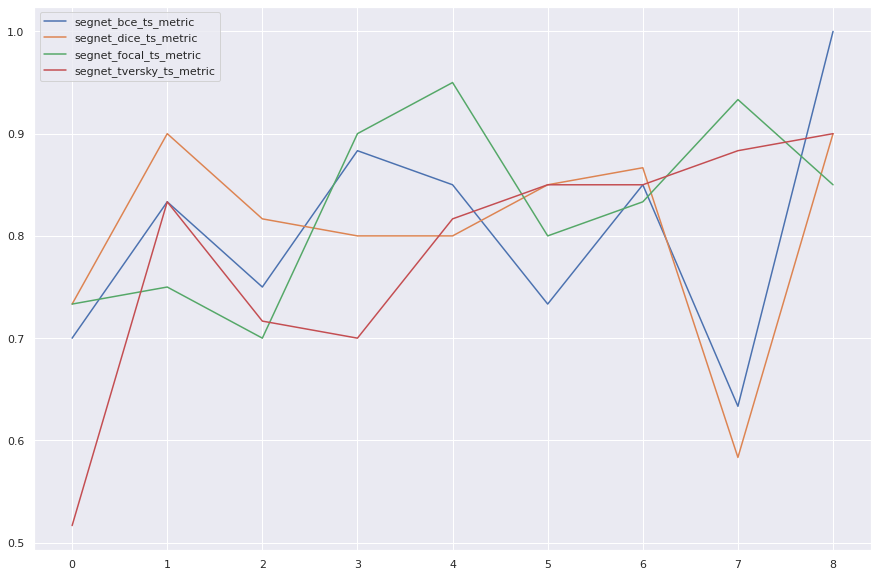

In [ ]:
segnet_bce_ts_metric = pd.Series(segnet_bce_ts_metric, name='segnet_bce_ts_metric')
segnet_dice_ts_metric = pd.Series(segnet_dice_ts_metric, name='segnet_dice_ts_metric')
segnet_focal_ts_metric = pd.Series(segnet_focal_ts_metric, name='segnet_focal_ts_metric')
segnet_tversky_ts_metric = pd.Series(segnet_tversky_ts_metric, name='segnet_tversky_ts_metric')

frames_metrics = [segnet_bce_ts_metric, segnet_dice_ts_metric, segnet_focal_ts_metric, segnet_tversky_ts_metric]
df_segnet_metrics = pd.concat(frames_metrics, axis=1)

plt.figure(figsize=(15,10))
plt.plot(df_segnet_metrics)
plt.legend(df_segnet_metrics.columns);

print('Среднее значение метрики на тестовой выборке:')
df_segnet_metrics.mean()

В численном выражении метрики лучше качество у SegNet с Focal loss.

-----------------------------------------------------------------------------------------

# U-Net

[**U-Net**](https://arxiv.org/abs/1505.04597) это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Учитывая медицинское изображение, он выводит изображение в оттенках серого, представляющее вероятность того, что каждый пиксель является интересующей областью.

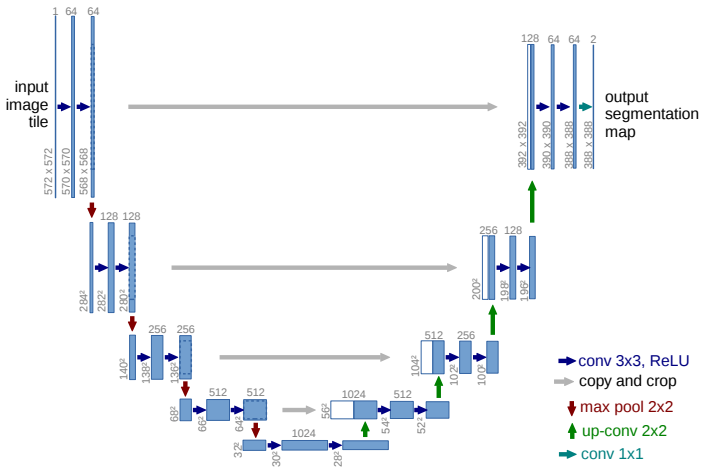

У нас в архитектуре все так же существует енкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются skip-conenctions. Элементы соединяющие части декодера и енкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNetBN(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = add_conv(3, 64, useBN=True)
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)  # 256 -> 128
        self.enc_conv1 = add_conv(64, 128, useBN=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128 -> 64
        self.enc_conv2 = add_conv(128, 256, useBN=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32
        self.enc_conv3 = add_conv(256, 512, useBN=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = add_conv(512, 1024, useBN=True)

        # decoder (upsampling)
        self.upsample0 = upsample(1024, 512) # 16 -> 32
        self.dec_conv0 = add_conv(1024, 512, useBN=True)
        self.upsample1 = upsample(512, 256) # 32 -> 64
        self.dec_conv1 = add_conv(512, 256, useBN=True)
        self.upsample2 = upsample(256, 128) # 64 -> 128
        self.dec_conv2 = add_conv(256, 128, useBN=True)
        self.upsample3 = upsample(128, 64) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            add_conv(128, 64, useBN=True),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # encoder
        e00 = self.enc_conv0(x)
        e01 = self.pool0(e00)
        e10 = self.enc_conv1(e01)
        e11 = self.pool1(e10)
        e20 = self.enc_conv2(e11)
        e21 = self.pool2(e20)
        e30 = self.enc_conv3(e21)
        e31 = self.pool3(e30)

        # bottleneck
        b = self.bottleneck_conv(e31)

        # decoder
        d0 = self.upsample0(b)
        d0 = self.dec_conv0(torch.cat((d0, e30), dim=1))
        d1 = self.upsample1(d0)
        d1 = self.dec_conv1(torch.cat((d1, e20), dim=1))
        d2 = self.upsample2(d1)
        d2 = self.dec_conv2(torch.cat((d2, e10), dim=1))
        d3 = self.upsample3(d2)
        d3 = self.dec_conv3(torch.cat((d3, e00), dim=1))  # no activation
        
        return d3

Модель UNetBN с BCE loss

In [ ]:
model_unetbn_bce = UNetBN().to(device)

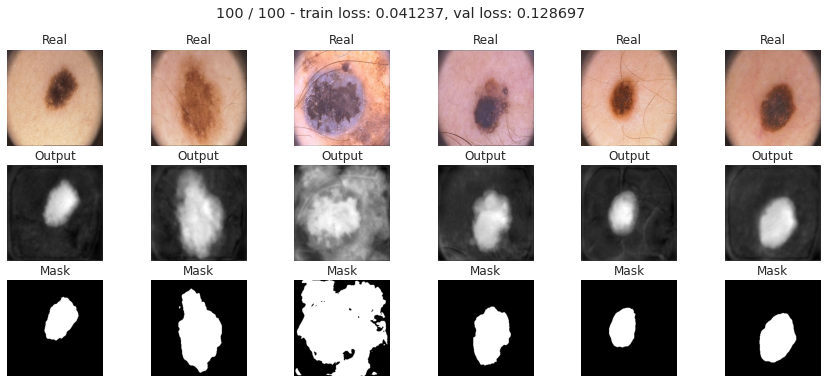

CPU times: user 14min 46s, sys: 9min 38s, total: 24min 24s
Wall time: 24min 25s


In [ ]:
%%time
max_epochs = 100
optimaizer = torch.optim.Adam(model_unetbn_bce.parameters(), lr=1e-4)
unetbn_bce_history = train(model_unetbn_bce, optimaizer, bce_loss, max_epochs, data_tr, data_val)

Сохраним веса

In [ ]:
torch.save(model_unetbn_bce.state_dict(), '/content/gdrive/MyDrive/Colab Notebooks/Model weights/model_unetbn_bce.pth')

In [ ]:
model_unetbn_bce.load_state_dict(torch.load('/content/gdrive/MyDrive/Colab Notebooks/Model weights/model_unetbn_bce.pth'))

<All keys matched successfully>

Сохраним лоссы

In [ ]:
unetbn_bce_tr_loss, unetbn_bce_val_loss = tr_val_loss(unetbn_bce_history)

In [ ]:
df_unetbn_bce = pd.DataFrame(unetbn_bce_val_loss, columns=['unet_bce_val_loss'])

In [ ]:
df_unetbn_bce.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Model weights/df_unetbn_bce.csv', index=False)

In [ ]:
df_unetbn_bce = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Model weights/df_unetbn_bce.csv')

Измерим метрики:

In [ ]:
unetbn_bce_tr_metric = score_model(model_unetbn_bce, iou_pytorch, data_tr)

Average IoU metric score: 0.9363


In [ ]:
unetbn_bce_val_metric = score_model(model_unetbn_bce, iou_pytorch, data_val)

Average IoU metric score: 0.8222


In [ ]:
unetbn_bce_ts_metric = score_model(model_unetbn_bce, iou_pytorch, data_ts)

Average IoU metric score: 0.8296


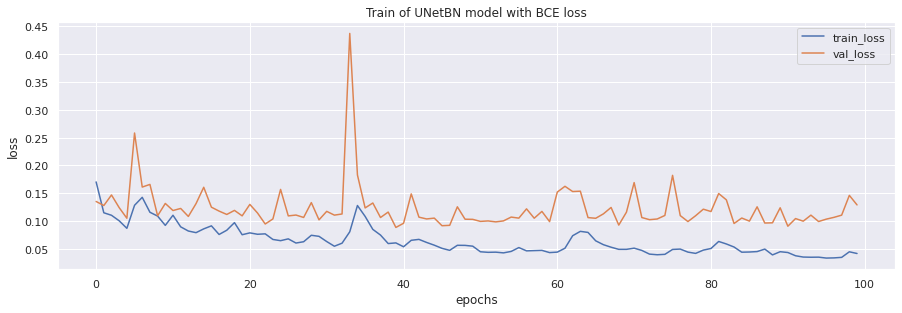

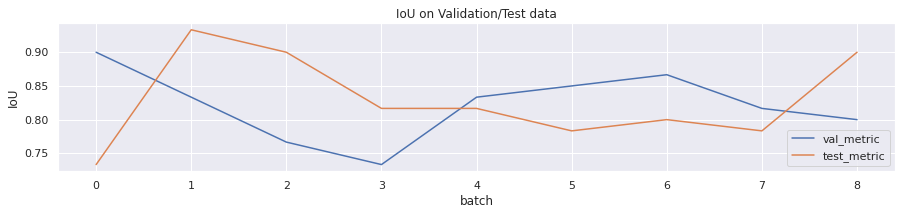

In [ ]:
train_curves_and_metrics(unetbn_bce_history, unetbn_bce_val_metric, unetbn_bce_ts_metric, 
                         'Train of UNetBN model with BCE loss',
                         'IoU on Validation/Test data')

Модель Unet с батч нормализацией сходиться быстрее  и показывает хорошее качество на тесте.

Модель UNetBN с dice loss

In [ ]:
model_unetbn_dice = UNetBN().to(device)

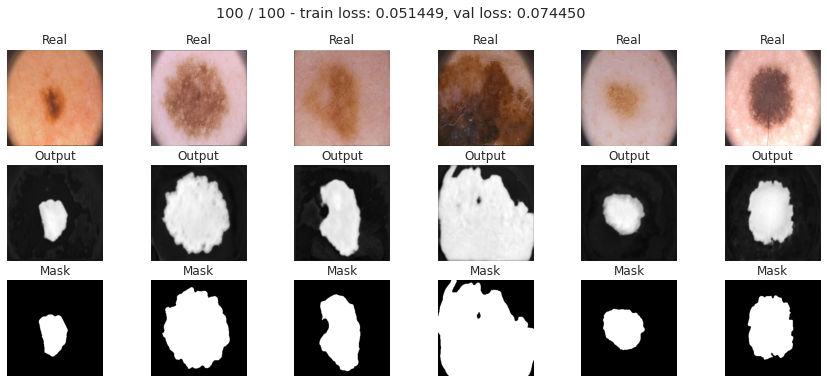

CPU times: user 14min 48s, sys: 9min 38s, total: 24min 27s
Wall time: 24min 28s


In [ ]:
%%time
max_epochs = 100
optimaizer = torch.optim.Adam(model_unetbn_dice.parameters(), lr=1e-4)
unetbn_dice_history = train(model_unetbn_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

Сохраним веса

In [ ]:
torch.save(model_unetbn_dice.state_dict(), '/content/gdrive/MyDrive/Colab Notebooks/Model weights/model_unetbn_dice.pth')

In [ ]:
model_unetbn_dice.load_state_dict(torch.load('/content/gdrive/MyDrive/Colab Notebooks/Model weights/model_unetbn_dice.pth'))

<All keys matched successfully>

Сохраним лоссы

In [ ]:
unetbn_dice_tr_loss, unetbn_dice_val_loss = tr_val_loss(unetbn_dice_history)

In [ ]:
df_unetbn_dice = pd.DataFrame(unetbn_dice_val_loss, columns=['unet_dice_val_loss'])

In [ ]:
df_unetbn_dice.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Model weights/df_unetbn_dice.csv', index=False)

In [ ]:
df_unetbn_dice = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Model weights/df_unetbn_dice.csv')

Измерим метрики:

In [ ]:
unetbn_dice_tr_metric = score_model(model_unetbn_dice, iou_pytorch, data_tr)

Average IoU metric score: 0.8647


In [ ]:
unetbn_dice_val_metric = score_model(model_unetbn_dice, iou_pytorch, data_val)

Average IoU metric score: 0.7648


In [ ]:
unetbn_dice_ts_metric = score_model(model_unetbn_dice, iou_pytorch, data_ts)

Average IoU metric score: 0.8037


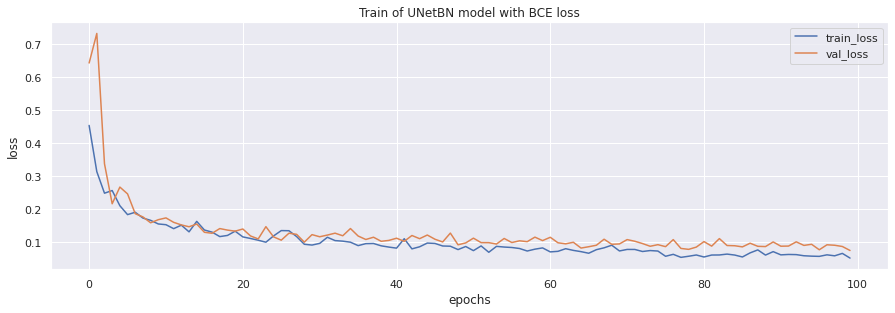

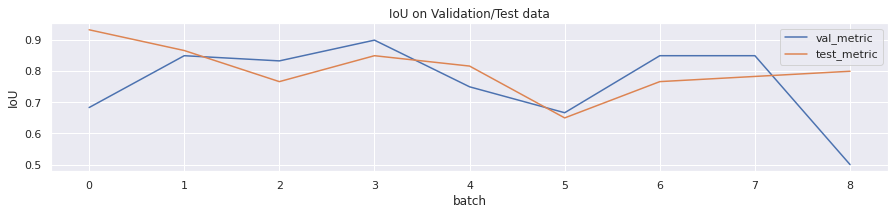

In [ ]:
train_curves_and_metrics(unetbn_dice_history, unetbn_dice_val_metric, unetbn_dice_ts_metric, 
                         'Train of UNetBN model with BCE loss',
                         'IoU on Validation/Test data')

С батч нормализацией модель сходиться быстрее.  
Далее будем использовать версию UNet с батч нормализацией

Модель UNetBN с focal loss

In [ ]:
model_unetbn_focal = UNetBN().to(device)

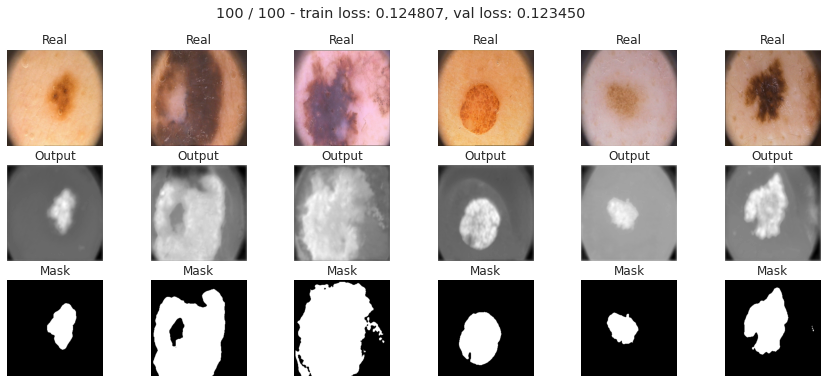

CPU times: user 14min 33s, sys: 9min 40s, total: 24min 13s
Wall time: 24min 14s


In [ ]:
%%time
max_epochs = 100
optimaizer = torch.optim.Adam(model_unetbn_focal.parameters(), lr=1e-4)
unetbn_focal_history = train(model_unetbn_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

Сохраним веса

In [ ]:
torch.save(model_unetbn_focal.state_dict(), '/content/gdrive/MyDrive/Colab Notebooks/Model weights/model_unetbn_focal.pth')

In [ ]:
model_unetbn_focal.load_state_dict(torch.load('/content/gdrive/MyDrive/Colab Notebooks/Model weights/model_unetbn_focal.pth'))

<All keys matched successfully>

Сохраним лоссы

In [ ]:
unetbn_focal_tr_loss, unetbn_focal_val_loss = tr_val_loss(unetbn_focal_history)

In [ ]:
df_unetbn_focal = pd.DataFrame(unetbn_focal_val_loss, columns=['unet_focal_val_loss'])

In [ ]:
df_unetbn_focal.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Model weights/df_unetbn_focal.csv', index=False)

In [ ]:
df_unetbn_focal = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Model weights/df_unetbn_focal.csv')

Измерим метрики:

In [ ]:
unetbn_focal_tr_metric = score_model(model_unetbn_focal, iou_pytorch, data_tr)

Average IoU metric score: 0.7500


In [ ]:
unetbn_focal_val_metric = score_model(model_unetbn_focal, iou_pytorch, data_val)

Average IoU metric score: 0.7093


In [ ]:
unetbn_focal_ts_metric = score_model(model_unetbn_focal, iou_pytorch, data_ts)

Average IoU metric score: 0.6630


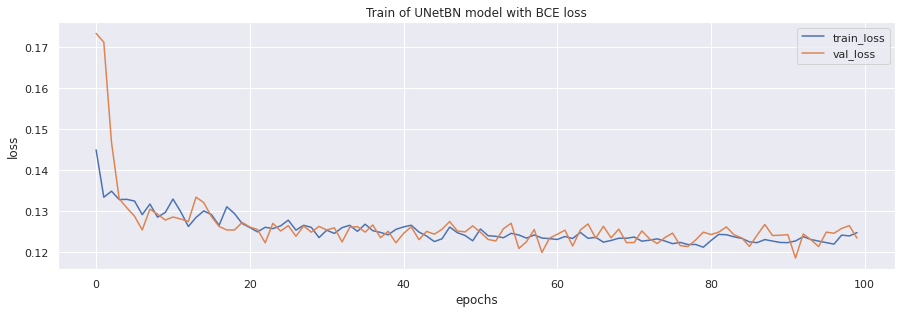

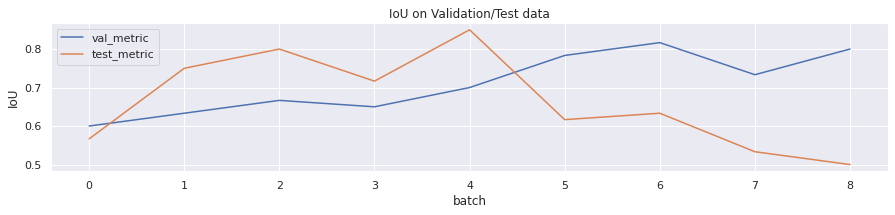

In [ ]:
train_curves_and_metrics(unetbn_focal_history, unetbn_focal_val_metric, unetbn_focal_ts_metric, 
                         'Train of UNetBN model with Focal loss',
                         'IoU on Validation/Test data')

По графикам не видно переобучения, хотя на тесте уступает BCE

Модель UNetBN с tvetsky loss

In [ ]:
model_unetbn_tvetsky = UNetBN().to(device)

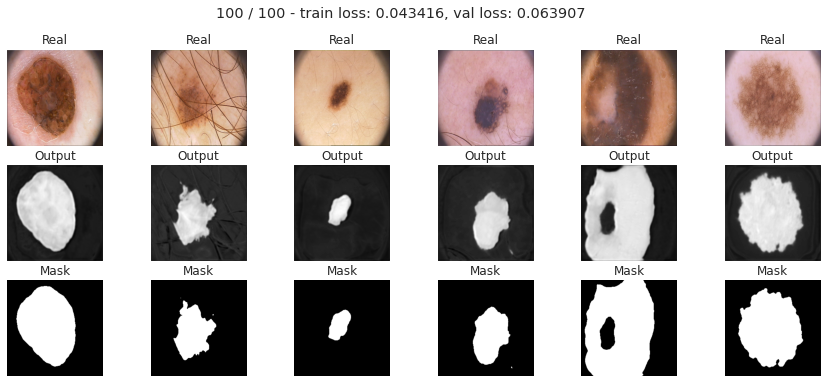

CPU times: user 14min 29s, sys: 9min 38s, total: 24min 8s
Wall time: 24min 9s


In [ ]:
%%time
max_epochs = 100
optimaizer = torch.optim.Adam(model_unetbn_tvetsky.parameters(), lr=1e-4)
unetbn_tvetsky_history = train(model_unetbn_tvetsky, optimaizer, tversky_loss, max_epochs, data_tr, data_val)

Сохраним веса

In [ ]:
torch.save(model_unetbn_tvetsky.state_dict(), '/content/gdrive/MyDrive/Colab Notebooks/Model weights/model_unetbn_tvetsky.pth')

In [ ]:
model_unetbn_tvetsky.load_state_dict(torch.load('/content/gdrive/MyDrive/Colab Notebooks/Model weights/model_unetbn_tvetsky.pth'))

<All keys matched successfully>

Сохраним лоссы

In [ ]:
unetbn_tvetsky_tr_loss, unetbn_tvetsky_val_loss = tr_val_loss(unetbn_tvetsky_history)

In [ ]:
df_unetbn_tvetsky = pd.DataFrame(unetbn_tvetsky_val_loss, columns=['unetbn_tvetsky_val_loss'])

In [ ]:
df_unetbn_tvetsky.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Model weights/df_unetbn_tvetsky.csv', index=False)

In [ ]:
df_unetbn_tvetsky = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Model weights/df_unetbn_tvetsky.csv')

Измерим метрики:

In [ ]:
unetbn_tversky_tr_metric = score_model(model_unetbn_tvetsky, iou_pytorch, data_tr)

Average IoU metric score: 0.8716


In [ ]:
unetbn_tversky_val_metric = score_model(model_unetbn_tvetsky, iou_pytorch, data_val)

Average IoU metric score: 0.7778


In [ ]:
unetbn_tversky_ts_metric = score_model(model_unetbn_tvetsky, iou_pytorch, data_ts)

Average IoU metric score: 0.7926


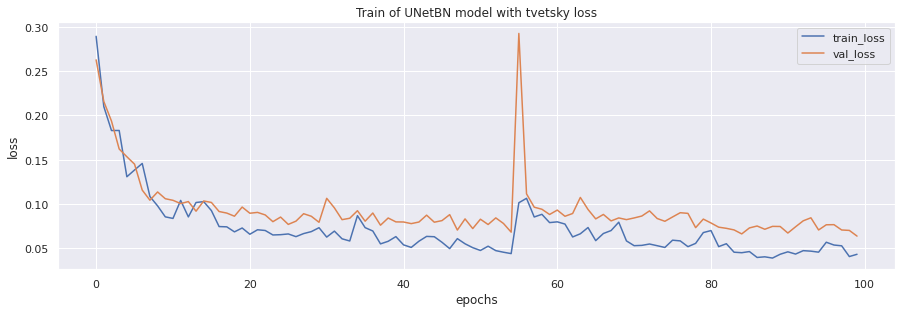

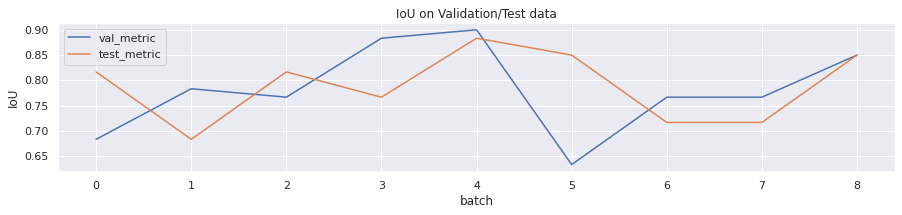

In [ ]:
train_curves_and_metrics(unetbn_tvetsky_history, unetbn_tvetsky_val_metric, unetbn_tvetsky_ts_metric, 
                         'Train of UNetBN model with tvetsky loss',
                         'IoU on Validation/Test data')

Модель с tversky loss не уходит в переобучение. но хуже по качеству на тестовой выборке чем BCE

Сравним все лоссы для модели UNet на валидации во время обучения:

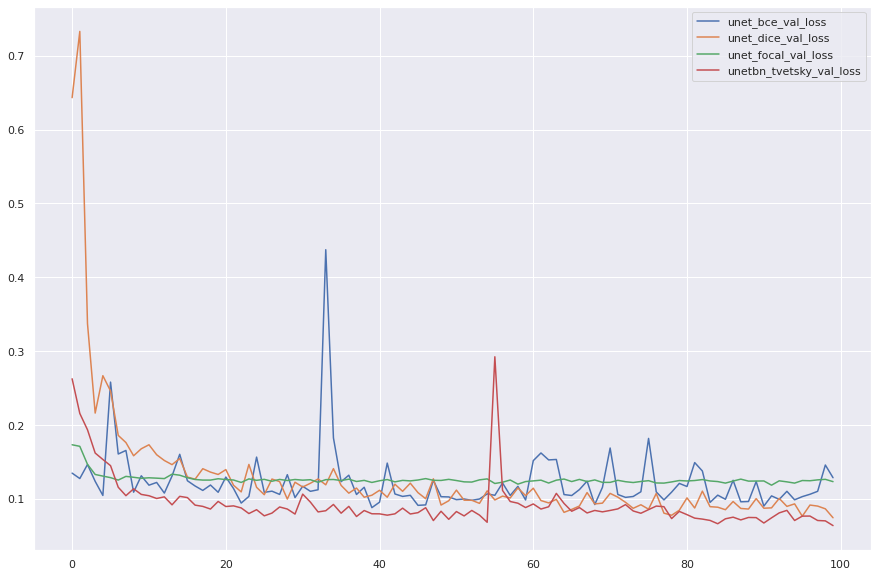

In [ ]:
frames_losses = [df_unetbn_bce, df_unetbn_dice, df_unetbn_focal, df_unetbn_tvetsky]
df_unetbn_losses = pd.concat(frames_losses, axis=1)

plt.figure(figsize=(15,10))
plt.plot(df_unetbn_losses)
plt.legend(df_unetbn_losses.columns);

Так же tversky loss имеет лучшую кривую на валидации по сравнению с остальными лоссами.

Построим графики метрики на тестовой выборке для модели с каждым из 4 лоссов:

Среднее значение метрики на тестовой выборке:


unetbn_bce_ts_metric        0.829630
unetbn_dice_ts_metric       0.803704
unetbn_focal_ts_metric      0.662963
unetbn_tversky_ts_metric    0.792593
dtype: float64

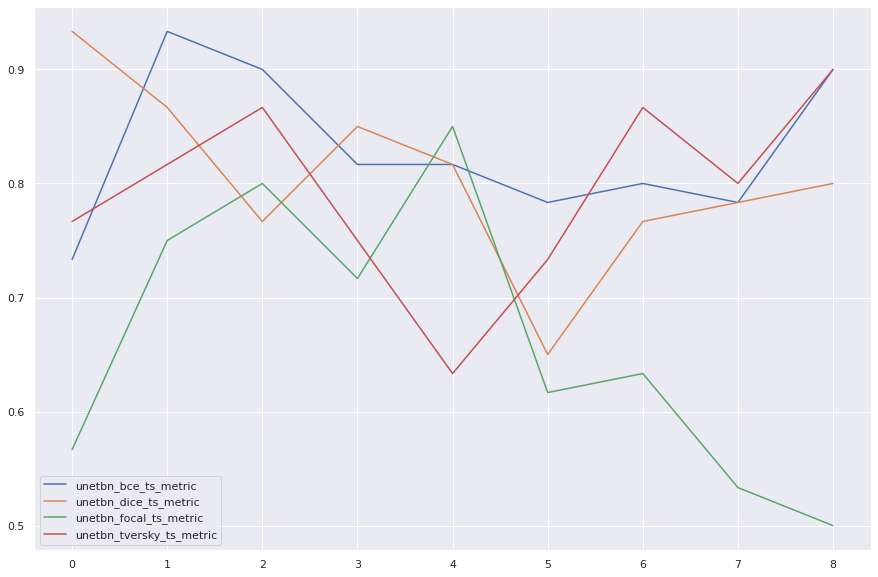

In [ ]:
unetbn_bce_ts_metric = pd.Series(unetbn_bce_ts_metric, name='unetbn_bce_ts_metric')
unetbn_dice_ts_metric = pd.Series(unetbn_dice_ts_metric, name='unetbn_dice_ts_metric')
unetbn_focal_ts_metric = pd.Series(unetbn_focal_ts_metric, name='unetbn_focal_ts_metric')
unetbn_tversky_ts_metric = pd.Series(unetbn_tversky_ts_metric, name='unetbn_tversky_ts_metric')

frames_metrics = [unetbn_bce_ts_metric, unetbn_dice_ts_metric, unetbn_focal_ts_metric, unetbn_tversky_ts_metric]
df_unetbn_metrics = pd.concat(frames_metrics, axis=1)

plt.figure(figsize=(15,10))
plt.plot(df_unetbn_metrics)
plt.legend(df_unetbn_metrics.columns);

print('Среднее значение метрики на тестовой выборке:')
df_unetbn_metrics.mean()

На тесте лучшее качество дала модель с BCE loss

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
def upsample2(dim_in, dim_out, kernel_size=4, stride=2, padding=1):
    return  nn.Sequential(
            nn.ConvTranspose2d(in_channels=dim_in, out_channels=dim_out, kernel_size=kernel_size, 
                               stride=stride, padding=padding),
            nn.ReLU()
        )

class UNetBN2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = add_conv(3, 64, useBN=True)
        self.pool0 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0)  # 256 -> 128
        self.enc_conv1 = add_conv(64, 128, useBN=True)
        self.pool1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, padding=0) # 128 -> 64
        self.enc_conv2 = add_conv(128, 256, useBN=True)
        self.pool2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2, stride=2, padding=0) # 64 -> 32
        self.enc_conv3 = add_conv(256, 512, useBN=True)
        self.pool3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=2, stride=2, padding=0) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = add_conv(512, 1024, useBN=True)

        # decoder (upsampling)
        self.upsample0 = upsample2(1024, 512) # 16 -> 32
        self.dec_conv0 = add_conv(1024, 512, useBN=True)
        self.upsample1 = upsample2(512, 256) # 32 -> 64
        self.dec_conv1 = add_conv(512, 256, useBN=True)
        self.upsample2 = upsample2(256, 128) # 64 -> 128
        self.dec_conv2 = add_conv(256, 128, useBN=True)
        self.upsample3 = upsample2(128, 64) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            add_conv(128, 64, useBN=True),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # encoder
        e00 = self.enc_conv0(x)
        e01 = self.pool0(e00)
        e10 = self.enc_conv1(e01)
        e11 = self.pool1(e10)
        e20 = self.enc_conv2(e11)
        e21 = self.pool2(e20)
        e30 = self.enc_conv3(e21)
        e31 = self.pool3(e30)

        # bottleneck
        b = self.bottleneck_conv(e31)

        # decoder
        d0 = self.upsample0(b)
        d0 = self.dec_conv0(torch.cat((d0, e30), dim=1))
        d1 = self.upsample1(d0)
        d1 = self.dec_conv1(torch.cat((d1, e20), dim=1))
        d2 = self.upsample2(d1)
        d2 = self.dec_conv2(torch.cat((d2, e10), dim=1))
        d3 = self.upsample3(d2)
        d3 = self.dec_conv3(torch.cat((d3, e00), dim=1))  # no activation
        
        return d3

Модель UNetBN2 с BCE loss

In [ ]:
model_unetbn2_bce = UNetBN2().to(device)

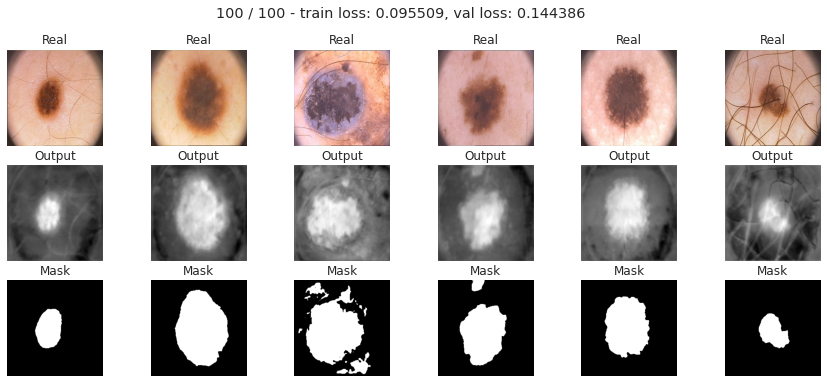

CPU times: user 14min 29s, sys: 9min 54s, total: 24min 24s
Wall time: 24min 25s


In [ ]:
%%time
max_epochs = 100
optimaizer = torch.optim.Adam(model_unetbn2_bce.parameters(), lr=1e-4)
unetbn2_bce_history = train(model_unetbn2_bce, optimaizer, bce_loss, max_epochs, data_tr, data_val)

Сохраним веса

In [ ]:
torch.save(model_unetbn2_bce.state_dict(), '/content/gdrive/MyDrive/Colab Notebooks/Model weights/model_unetbn2_bce.pth')

In [ ]:
model_unetbn2_bce.load_state_dict(torch.load('/content/gdrive/MyDrive/Colab Notebooks/Model weights/model_unetbn2_bce.pth'))

<All keys matched successfully>

Сохраним лоссы

In [ ]:
unetbn2_bce_tr_loss, unetbn2_bce_val_loss = tr_val_loss(unetbn2_bce_history)

In [ ]:
df_unetbn2_bce = pd.DataFrame(unetbn2_bce_val_loss, columns=['unetbn2_bce_val_loss'])

In [ ]:
df_unetbn2_bce.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Model weights/df_unetbn2_bce.csv', index=False)

In [ ]:
df_unetbn2_bce = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Model weights/df_unetbn2_bce.csv')

Измерим метрики:

In [ ]:
unetbn2_bce_tr_metric = score_model(model_unetbn2_bce, iou_pytorch, data_tr)

Average IoU metric score: 0.8529


In [ ]:
unetbn2_bce_val_metric = score_model(model_unetbn2_bce, iou_pytorch, data_val)

Average IoU metric score: 0.7778


In [ ]:
unetbn2_bce_ts_metric = score_model(model_unetbn2_bce, iou_pytorch, data_ts)

Average IoU metric score: 0.7648


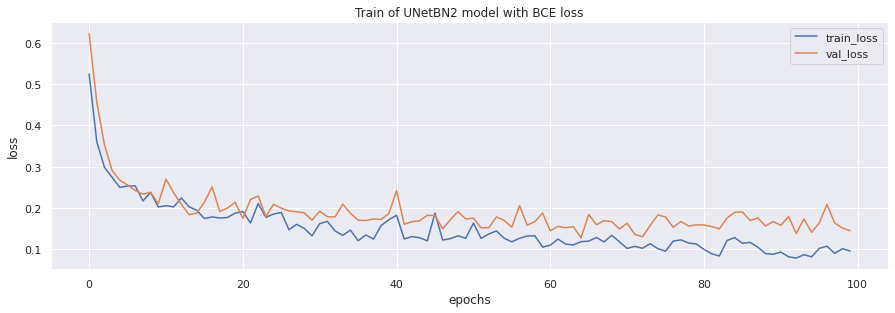

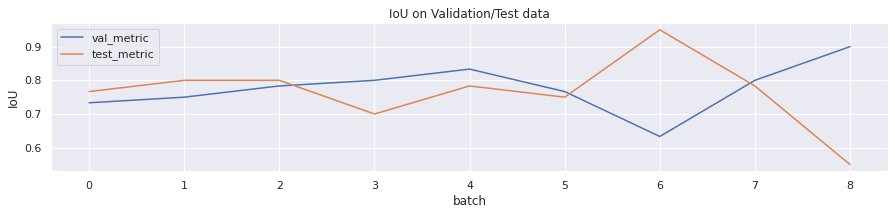

In [ ]:
train_curves_and_metrics(unetbn2_bce_history, unetbn2_bce_val_metric, unetbn2_bce_ts_metric, 
                         'Train of UNetBN2 model with BCE loss',
                         'IoU on Validation/Test data')

Заметно переобучение с 60 эпохи, на тесте средний показатель

Модель UNetBN2 с dice loss

In [ ]:
model_unetbn2_dice = UNetBN().to(device)

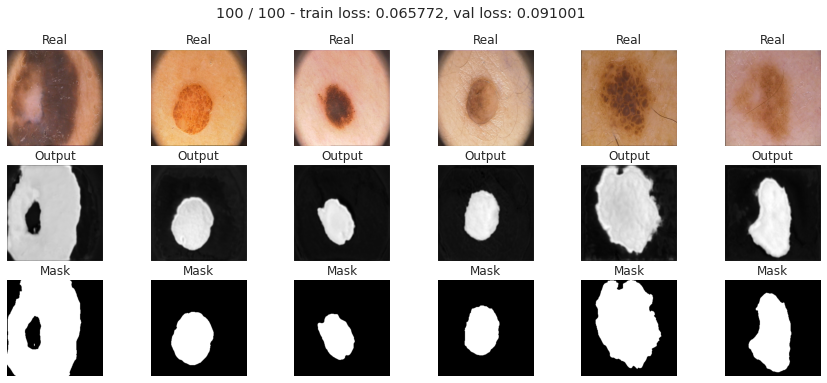

CPU times: user 14min 33s, sys: 9min 39s, total: 24min 12s
Wall time: 24min 13s


In [ ]:
%%time
max_epochs = 100
optimaizer = torch.optim.Adam(model_unetbn2_dice.parameters(), lr=1e-4)
unetbn2_dice_history = train(model_unetbn2_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

Сохраним веса

In [ ]:
torch.save(model_unetbn2_dice.state_dict(), '/content/gdrive/MyDrive/Colab Notebooks/Model weights/model_unetbn2_dice.pth')

In [ ]:
model_unetbn2_dice.load_state_dict(torch.load('/content/gdrive/MyDrive/Colab Notebooks/Model weights/model_unetbn2_dice.pth'))

<All keys matched successfully>

Сохраним лоссы

In [ ]:
unetbn_dice_tr_loss, unetbn_dice_val_loss = tr_val_loss(unetbn2_dice_history)

In [ ]:
df_unetbn2_dice = pd.DataFrame(unetbn_dice_val_loss, columns=['unetbn2_dice_val_loss'])

In [ ]:
df_unetbn2_dice.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Model weights/df_unetbn2_dice.csv', index=False)

In [ ]:
df_unetbn2_dice = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Model weights/df_unetbn2_dice.csv')

Измерим метрики:

In [ ]:
unetbn2_dice_tr_metric = score_model(model_unetbn2_dice, iou_pytorch, data_tr)

Average IoU metric score: 0.8559


In [ ]:
unetbn2_dice_val_metric = score_model(model_unetbn2_dice, iou_pytorch, data_val)

Average IoU metric score: 0.7556


In [ ]:
unetbn2_dice_ts_metric = score_model(model_unetbn2_dice, iou_pytorch, data_ts)

Average IoU metric score: 0.8037


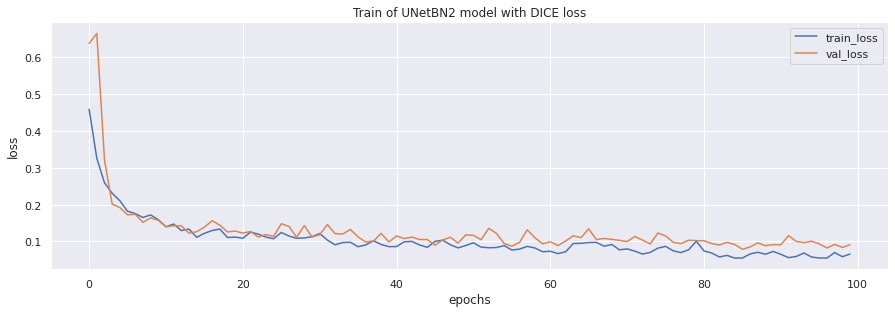

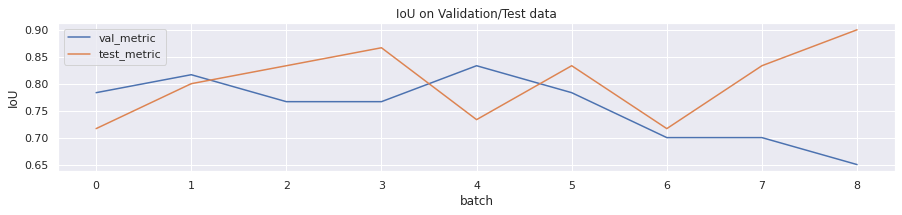

In [ ]:
train_curves_and_metrics(unetbn2_dice_history, unetbn2_dice_val_metric, unetbn2_dice_ts_metric, 
                         'Train of UNetBN2 model with DICE loss',
                         'IoU on Validation/Test data')

С DICE loss не видно переобучения на графиках и хороший скор на тесте 0.80

Модель UNetBN2 с focal loss

In [ ]:
model_unetbn2_focal = UNetBN().to(device)

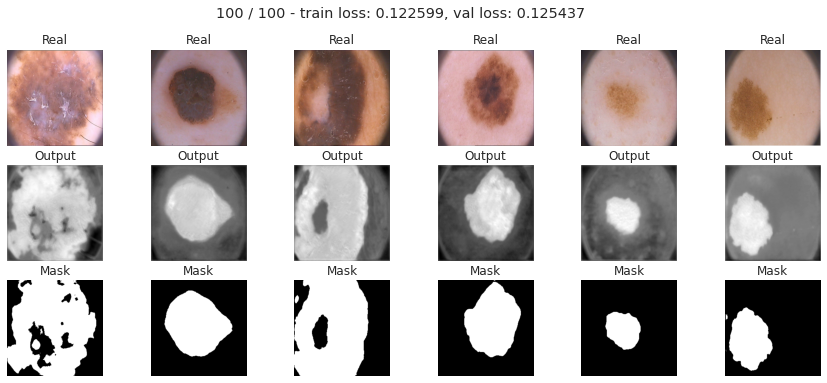

CPU times: user 14min 29s, sys: 9min 38s, total: 24min 8s
Wall time: 24min 8s


In [ ]:
%%time
max_epochs = 100
optimaizer = torch.optim.Adam(model_unetbn2_focal.parameters(), lr=1e-4)
unetbn2_focal_history = train(model_unetbn2_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

Сохраним веса

In [ ]:
torch.save(model_unetbn2_focal.state_dict(), '/content/gdrive/MyDrive/Colab Notebooks/Model weights/model_unetbn2_focal.pth')

In [ ]:
model_unetbn2_focal.load_state_dict(torch.load('/content/gdrive/MyDrive/Colab Notebooks/Model weights/model_unetbn2_focal.pth'))

<All keys matched successfully>

Сохраним лоссы

In [ ]:
unetbn2_focal_tr_loss, unetbn2_focal_val_loss = tr_val_loss(unetbn2_focal_history)

In [ ]:
df_unetbn2_focal = pd.DataFrame(unetbn2_focal_val_loss, columns=['unetbn2_focal_val_loss'])

In [ ]:
df_unetbn2_focal.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Model weights/df_unetbn2_focal.csv', index=False)

In [ ]:
df_unetbn2_focal = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Model weights/df_unetbn2_focal.csv')

Измерим метрики:

In [ ]:
unetbn2_focal_tr_metric = score_model(model_unetbn2_focal, iou_pytorch, data_tr)

Average IoU metric score: 0.8529


In [ ]:
unetbn2_focal_val_metric = score_model(model_unetbn2_focal, iou_pytorch, data_val)

Average IoU metric score: 0.7667


In [ ]:
unetbn2_focal_ts_metric = score_model(model_unetbn2_focal, iou_pytorch, data_ts)

Average IoU metric score: 0.7741


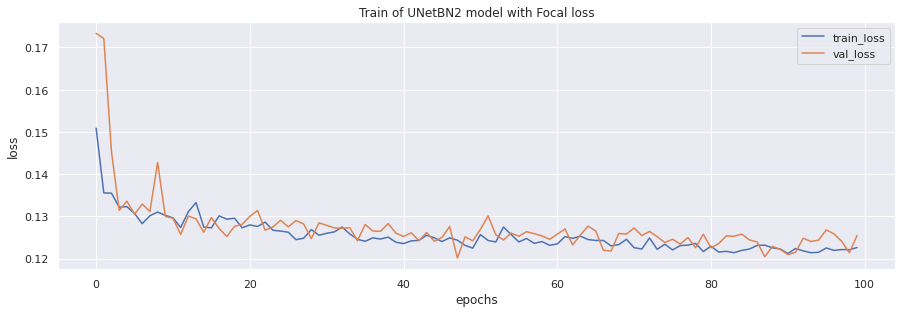

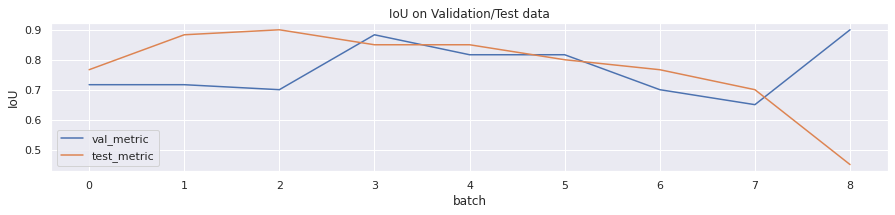

In [ ]:
train_curves_and_metrics(unetbn2_focal_history, unetbn2_focal_val_metric, unetbn2_focal_ts_metric, 
                         'Train of UNetBN2 model with Focal loss',
                         'IoU on Validation/Test data')

переобучения не видно, но скор ниже DICE

Модель UNetBN2 с tversky loss

In [ ]:
model_unetbn2_tvetsky = UNetBN().to(device)

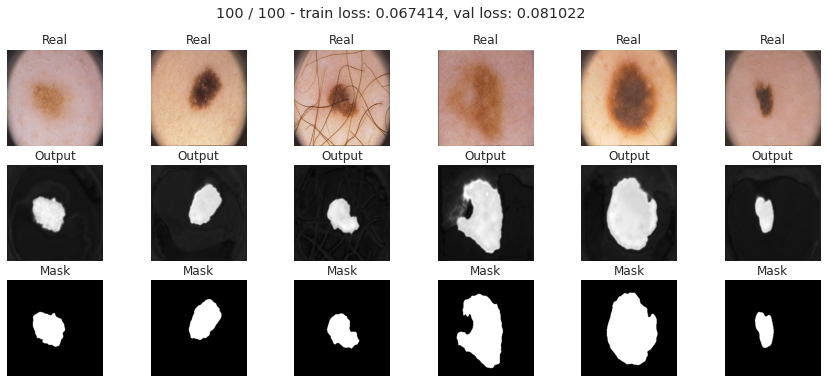

CPU times: user 14min 29s, sys: 9min 39s, total: 24min 9s
Wall time: 24min 10s


In [ ]:
%%time
max_epochs = 100
optimaizer = torch.optim.Adam(model_unetbn2_tvetsky.parameters(), lr=1e-4)
unetbn2_tvetsky_history = train(model_unetbn2_tvetsky, optimaizer, tversky_loss, max_epochs, data_tr, data_val)

Сохраним веса

In [ ]:
torch.save(model_unetbn2_tvetsky.state_dict(), '/content/gdrive/MyDrive/Colab Notebooks/Model weights/model_unetbn2_tvetsky.pth')

In [ ]:
model_unetbn2_tvetsky.load_state_dict(torch.load('/content/gdrive/MyDrive/Colab Notebooks/Model weights/model_unetbn2_tvetsky.pth'))

<All keys matched successfully>

Сохраним лоссы

In [ ]:
unetbn2_tvetsky_tr_loss, unetbn2_tvetsky_val_loss = tr_val_loss(unetbn2_tvetsky_history)

In [ ]:
df_unetbn2_tvetsky = pd.DataFrame(unetbn2_tvetsky_val_loss, columns=['unetbn2_tvetsky_val_loss'])

In [ ]:
df_unetbn2_tvetsky.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Model weights/df_unetbn2_tvetsky.csv', index=False)

In [ ]:
df_unetbn2_tvetsky = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Model weights/df_unetbn2_tvetsky.csv')

Измерим метрики:

In [ ]:
unetbn2_tversky_tr_metric = score_model(model_unetbn2_tvetsky, iou_pytorch, data_tr)

Average IoU metric score: 0.7725


In [ ]:
unetbn2_tversky_val_metric = score_model(model_unetbn2_tvetsky, iou_pytorch, data_val)

Average IoU metric score: 0.7167


In [ ]:
unetbn2_tversky_ts_metric = score_model(model_unetbn2_tvetsky, iou_pytorch, data_ts)

Average IoU metric score: 0.7167


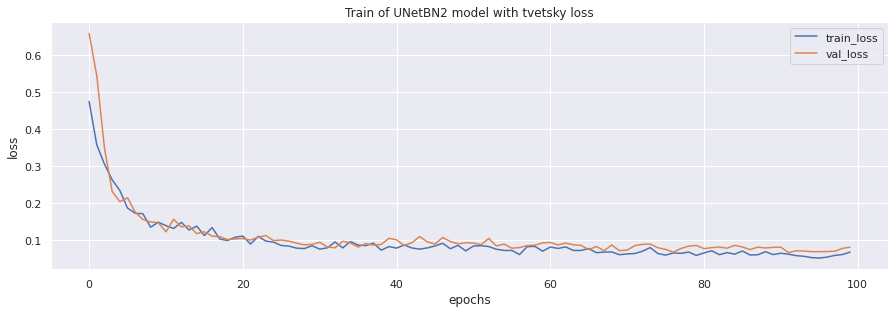

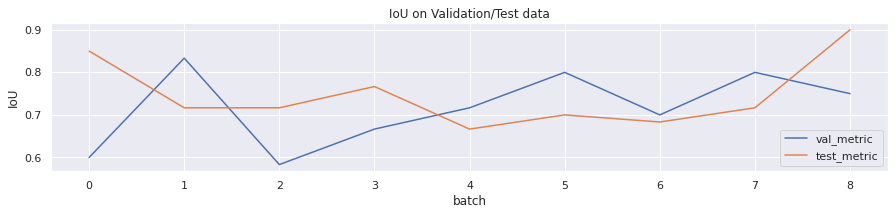

In [ ]:
train_curves_and_metrics(unetbn2_tvetsky_history, unetbn2_tvetsky_val_metric, unetbn2_tvetsky_ts_metric, 
                         'Train of UNetBN2 model with tvetsky loss',
                         'IoU on Validation/Test data')

Модель не переобучается, но скор самый низкий из 4 лоссов на тесте

Сравним все лоссы для модели UNet2 на валидации во время обучения:

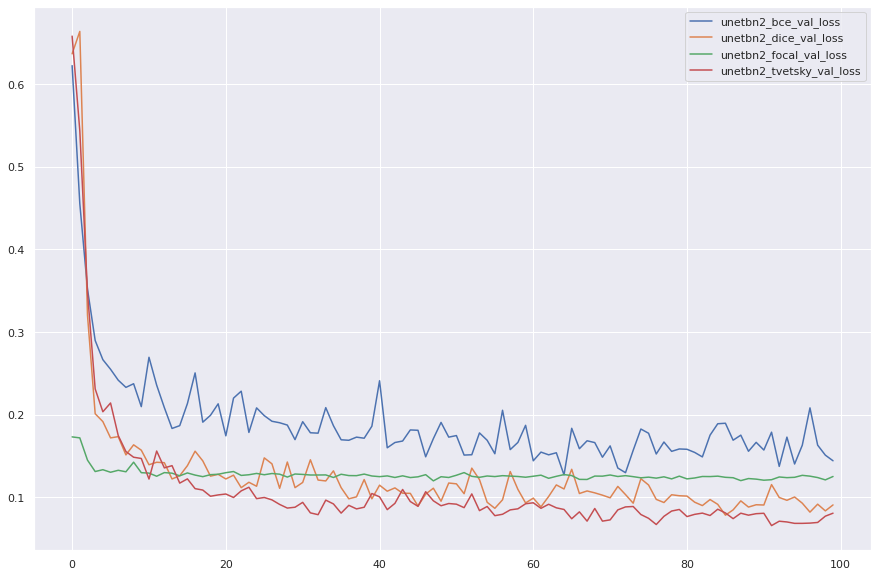

In [ ]:
frames_losses = [df_unetbn2_bce, df_unetbn2_dice, df_unetbn2_focal, df_unetbn2_tvetsky]
df_unetbn2_losses = pd.concat(frames_losses, axis=1)

plt.figure(figsize=(15,10))
plt.plot(df_unetbn2_losses)
plt.legend(df_unetbn2_losses.columns);

Лучшая кривая на валидации у tversky loss, самая стабильная опять же focal

Построим графики метрики на тестовой выборке для модели с каждым из 4 лоссов:

Среднее значение метрики на тестовой выборке:


unetbn2_bce_ts_metric        0.764815
unetbn2_dice_ts_metric       0.803704
unetbn2_focal_ts_metric      0.774074
unetbn2_tversky_ts_metric    0.716667
dtype: float64

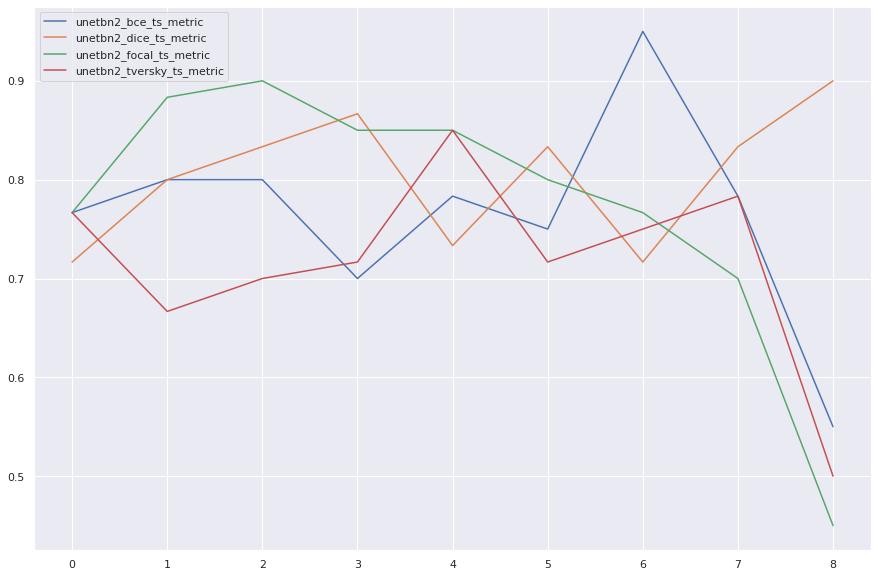

In [ ]:
unetbn2_bce_ts_metric = pd.Series(unetbn2_bce_ts_metric, name='unetbn2_bce_ts_metric')
unetbn2_dice_ts_metric = pd.Series(unetbn2_dice_ts_metric, name='unetbn2_dice_ts_metric')
unetbn2_focal_ts_metric = pd.Series(unetbn2_focal_ts_metric, name='unetbn2_focal_ts_metric')
unetbn2_tversky_ts_metric = pd.Series(unetbn2_tversky_ts_metric, name='unetbn2_tversky_ts_metric')

frames_metrics = [unetbn2_bce_ts_metric, unetbn2_dice_ts_metric, unetbn2_focal_ts_metric, unetbn2_tversky_ts_metric]
df_unetbn2_metrics = pd.concat(frames_metrics, axis=1)

plt.figure(figsize=(15,10))
plt.plot(df_unetbn2_metrics)
plt.legend(df_unetbn2_metrics.columns);

print('Среднее значение метрики на тестовой выборке:')
df_unetbn2_metrics.mean()

Лучший лосс на тесте показывает DICE

Сравним топ 3 модели с их лучшими лоссами:

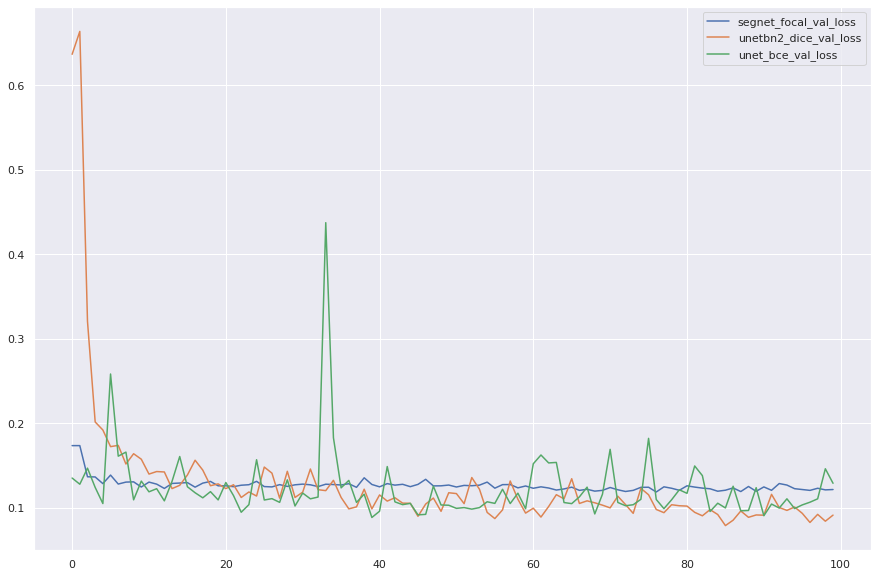

In [ ]:
frames_losses = [df_segnet_focal, df_unetbn2_dice, df_unetbn_bce]
df_top_3_model = pd.concat(frames_losses, axis=1)

plt.figure(figsize=(15,10))
plt.plot(df_top_3_model)
plt.legend(df_top_3_model.columns);

SegNet Focal очень стабильно предсказывает на валидации, обе модели UNet практически равны визуально.

Среднее значение метрики на тестовой выборке:


segnet_focal_ts_metric    0.827778
unetbn_bce_ts_metric      0.829630
unetbn2_dice_ts_metric    0.803704
dtype: float64

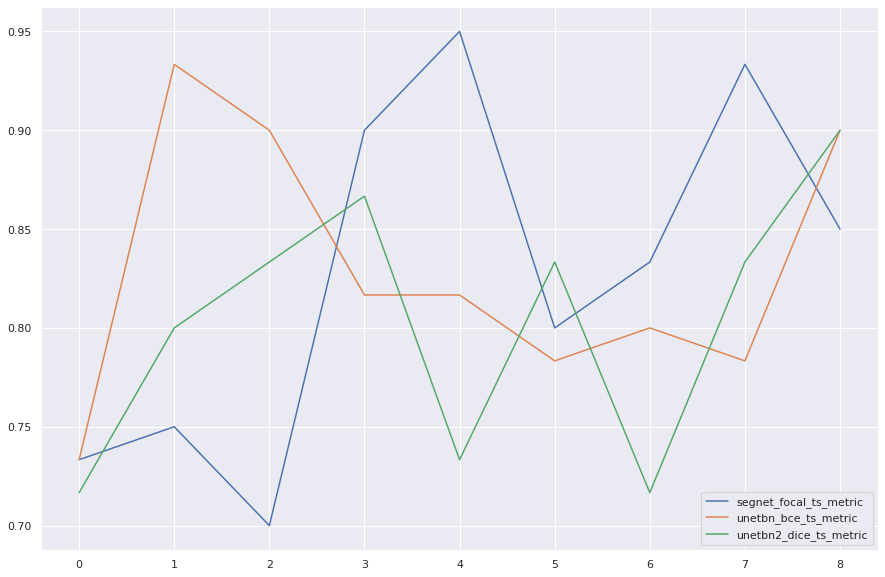

In [ ]:
frames_metrics = [segnet_focal_ts_metric, unetbn_bce_ts_metric, unetbn2_dice_ts_metric]
df_top3_model_metrics = pd.concat(frames_metrics, axis=1)

plt.figure(figsize=(15,10))
plt.plot(df_top3_model_metrics)
plt.legend(df_top3_model_metrics.columns);

print('Среднее значение метрики на тестовой выборке:')
df_top3_model_metrics.mean()

UNet BCE показывает скор немного выше, однако Unet Focal более равномерно дает предсказания и ошибается так же.  
Победитель - UnetBN Focal

## Общий вывод:
Все 3 модели из топ 3 показывают хорошее качество > 0.80.
Тем неменее UNet обучется в 2 раза дольше, 24 мин против 12 (при текущем количестве объектов на трейне).
Это связано количеством параметров.
При росте числа объектов получим существенное увелечение времени обучения.  
Поэтому нужно изходить из целей заказчика, делать быстрее или качественнее. Однако, говоря о медецинских исследованиях которые влияют здоровье, возможно, приоритет будет в сторону качества.  
По качеству картинок можно сказать, что модели делают прогноз достаточно хорошо и в датасете присутствуют картинки мелономы редкие и уникальные, на них модели сильно получают ошибку.